## K-means Clustering

## Content

### 1. <a href = '#Introduction'>Introduction</a>
### 2. <a href = '#EDA'>EDA</a>
### 3. <a href = '#Feature Engineering'>Feature engineering</a>
### 4. <a href = '#Optimal Cluster Selection'>Optimal Cluster Selection</a>
### 5. <a href = '#Kmeans Clustering'>Kmeans Clustering</a>

## Introduction

Partitioning a set of objects in datasets into homogeneous groups or clusters is a fundamental operation in a number of tasks,such as classification in unsupervised learning.

Clustering methods partition a set of objects into clusters such that objects in the same cluster are more similar
to each other than objects in different clusters according to some defined criteria.

### The k-means algorithm
The k-means algorithm is one of the mostly used
clustering algorithms, it is classified as a partitional or nonhierarchical clustering method. 

k-means algorithm assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster.

### Objective of this assignment 

Clustering whiskey distilleries according to tasting Profiles

## EDA

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.figure_factory as ff
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import KernelPCA

from itertools import zip_longest
from IPython.display import HTML, display



%matplotlib inline 
#plt.style.use('ggplot')

In [31]:
df = pd.read_csv('../data/whisky.csv')

In [32]:
#Checking for duplicated rows in the data frame
duplicates = df.duplicated(keep = False)
print(duplicates.unique())

[False]


- The false value above indicates that the status of duplicated entries is False, implying that each row/entry in the data set is unique

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 17 columns):
RowID         86 non-null int64
Distillery    86 non-null object
Body          86 non-null int64
Sweetness     86 non-null int64
Smoky         86 non-null int64
Medicinal     86 non-null int64
Tobacco       86 non-null int64
Honey         86 non-null int64
Spicy         86 non-null int64
Winey         86 non-null int64
Nutty         86 non-null int64
Malty         86 non-null int64
Fruity        86 non-null int64
Floral        86 non-null int64
Postcode      86 non-null object
Latitude      86 non-null int64
Longitude     86 non-null int64
dtypes: int64(15), object(2)
memory usage: 11.5+ KB


- When dealing with kmeans clustering, ideally i need my dataset to be numeric values, already i can see that this dataset has two object variables : Distillery and Postcode.
- Since the purpose of this assignment is to cluster whiskey distilleries according to their tasting profiles, i will not need postcode hence i do not need to refine it to conform to kmeans clustering's standard.
- I may need to standardize Distillery either by label encoding or getting its dummy variables.
- Without any accuracy score of the kmeans model to back up my opinion,i think that getting dummy variables will be better since it will not teach the model that the one distillery is more important than the other, although dummy variables will take up much of my space
- Body is a variable that i plan to drop since it is not a variable that literally contributes to the taste of any whiskey

In [34]:
#Dropping unncessary columns
dropList = df[['RowID', 'Body', 'Postcode', 'Latitude', 'Longitude']]
whisky = df.drop(dropList, axis = 1)

In [35]:
whisky.head()

,Distillery,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral
0,Aberfeldy,2,2,0,0,2,1,2,2,2,2,2
1,Aberlour,3,1,0,0,4,3,2,2,3,3,2
2,AnCnoc,3,2,0,0,2,0,0,2,2,3,2
3,Ardbeg,1,4,4,0,0,2,0,1,2,1,0
4,Ardmore,2,2,0,0,1,1,1,2,3,1,1


In [36]:
# Dataset's statistic description
whisky.describe(include = "all")

,Distillery,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral
count,86,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
unique,86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Teaninich,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.290698,1.534884,0.546512,0.116279,1.244186,1.383721,0.976744,1.465116,1.802326,1.802326,1.697674
std,NaN,0.717287,0.863613,0.990032,0.322439,0.853175,0.784686,0.932760,0.821730,0.629094,0.779438,0.855017
min,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
50%,NaN,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000
75%,NaN,3.000000,2.000000,1.000000,0.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000


In [37]:
whisky[whisky['Distillery'] == 'Balmenach']

,Distillery,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral
10,Balmenach,3,2,0,0,2,1,3,3,0,1,2


- The Dataset's statistic description indicates that a distillery called Balmenach has the most common values however with only one occurrence of the distillery itself. This means that the taste profile of Balmenach has the overall score thats above all other distilleries. This points out that different distillery's make varying whiskeys, which has a combination of different flavours / tasting profiles.
- Since the dataset at this point is categorical, i cannot derive substantial meaning from looking at the data's statistical description, however i can get an idea of the proportions of each category for each flavour.
- In order for me to have more understanding of the implication the data has, i may need to create new features, or transform the data all together before implementing kmeans.
- I suspect that the different numbers in each column could be a scale of measuring the intensity of the flavour, however at this point there is no way for me to justify my assumptions, at least not yet

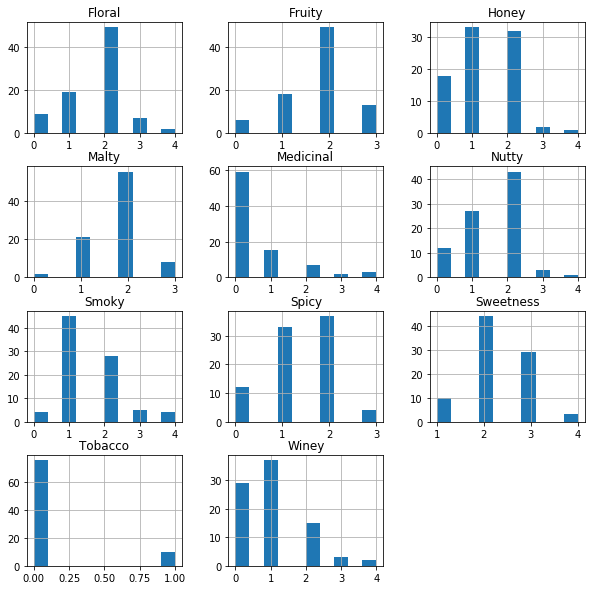

In [38]:
# Propotions
whisky.hist(figsize=(10,10))
plt.show()

##### The histogram plots above show that:

- About 64% of the flavours have a greatest count of value 2
- Honey and Spicy has similar proportions of value 1 and 2, maybe these flavours will appear in all clusters if not most
- Medicinal and Tobacco's highest count is value 0, it wouldn't surprise me if these flavours are rarely found in any cluster is found at all

#### Correlation

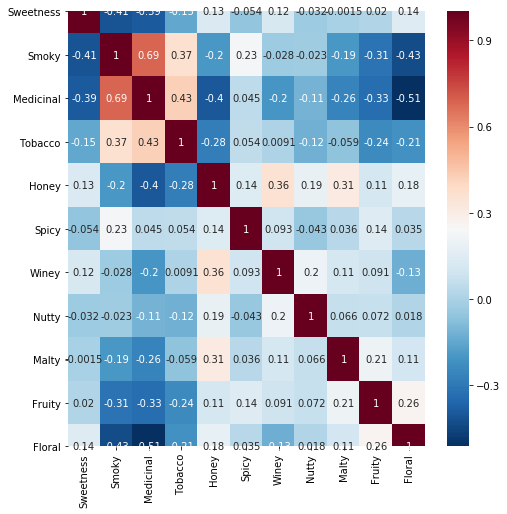

In [39]:
corr = whisky.corr(method='pearson')
plt.figure(figsize=(8,8))
sns.heatmap(corr,cmap='RdBu_r',annot=True);

- Smoky and Medicinal have the highest correlation score of 0.686, which suggest a relation between the features,therefor seeing these features in the same cluster would be understandable

<a id='Feature Engineering'></a>

## Feature Engineering

- Select features
- Standardize features

In [40]:
whisky_features = whisky.drop(['Distillery'],axis = 1)
whisky_features.columns.values

array(['Sweetness', 'Smoky', 'Medicinal', 'Tobacco', 'Honey', 'Spicy',
       'Winey', 'Nutty', 'Malty', 'Fruity', 'Floral'], dtype=object)

- Since clustering algorithms including kmeans use distance-based measurements to determine the similarity between data points, it is recommended to standardize the data to have a mean of zero and a standard deviation of one. This process is not necessary in this case since the data falls in the interval of [0,4]

<a id='Optimal Cluster Selection'></a>

## Optimal Cluster Selection

- <a href = '#Dendrogram'>Dendrogram</a>
- <a href = '#Principal Component Analysis'>Principal Component Analysis</a>
- Elbow Method
- Silhouette score

<a id='Dendrogram'></a>

In [41]:
distilleries = whisky['Distillery'].tolist()
whisky_features = whisky.drop(['Distillery'],axis = 1)

fig = ff.create_dendrogram(whisky_features, orientation='bottom', labels=distilleries)
fig.update_layout({'width':750,'height':600,
                         'title': 'Whisky dendrogram',
                         'yaxis': {'title':'Distance'}})
fig.show()

- Even though the main use of a dendrogram is to work out the best way to allocate objects to clusters, in this case, the dendrogram does not indicate the number of clusters to use and this visualization is too messy to read and interpret since there are so many distilleries.

- At this point the dataset has multiple dimensions which is not ideal to use for elbow method or silhouette score, therefore i will need to reduce the dimensionality to an extent that the resulting variables explains the maximum variance within the dataset.

- This can be achieved through *Principal Component Analysis*

<a id='Principal Component Analysis'></a>

In [42]:
np.random.seed(30)
rbf_pca= KernelPCA(n_components=2, kernel='rbf')
whisky_features_reduced = rbf_pca.fit_transform(whisky_features)

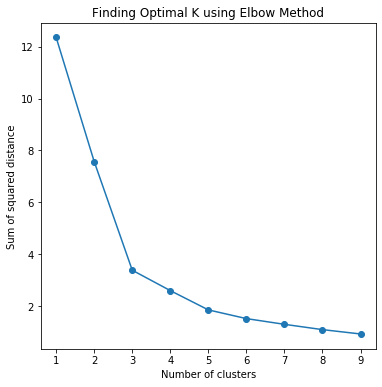

In [43]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(whisky_features_reduced)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.title('Finding Optimal K using Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance');

- According to the elbow method above, 3,4,5 and 6 seem to be good clusters, however the elbow method alone does not give me enough confidence to conclude on the optimal number of clusters.
- I will than calculate silhouette scores of each cluster to help me choose an optimal cluster 

In [44]:
sil_coeffs = []

for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(whisky_features_reduced)
    label = kmeans.labels_
    sil_coeff = silhouette_score(whisky_features_reduced, label, metric='euclidean')
    sil_coeffs.append(sil_coeff)
    print(f"{n_cluster} for clusters: Silhouette Coefficient = {sil_coeff}")

2 for clusters: Silhouette Coefficient = 0.4200699619529406
3 for clusters: Silhouette Coefficient = 0.4931345091870144
4 for clusters: Silhouette Coefficient = 0.4182916316911331
5 for clusters: Silhouette Coefficient = 0.437268096859986
6 for clusters: Silhouette Coefficient = 0.3948044713683115
7 for clusters: Silhouette Coefficient = 0.39912084289616323
8 for clusters: Silhouette Coefficient = 0.40506567543090577
9 for clusters: Silhouette Coefficient = 0.40979037748120145
10 for clusters: Silhouette Coefficient = 0.42227787680415435


- 3 clusters seem optimal because the silhouette score of 0.49 is the closest to 1, which means, 3 clusters correctly grouped similar features together.

<a id='Kmeans Clustering'></a>

## Kmeans Clustering

- Modeling
- Visualizations
    - Plots
    - Cluster Centers
    - kmeans labels
- Insights

In [45]:
kmeans_2_clusters = KMeans(n_clusters=2,random_state=0)
pred_y_2_clusters = kmeans_2_clusters.fit_predict(whisky_features_reduced)

kmeans_3_clusters = KMeans(n_clusters=3,random_state=0)
pred_y_3_clusters = kmeans_3_clusters.fit_predict(whisky_features_reduced)

kmeans_4_clusters = KMeans(n_clusters=4,random_state=0)
pred_y_4_clusters = kmeans_4_clusters.fit_predict(whisky_features_reduced)

In [46]:
x=whisky_features_reduced[:,0]
y=whisky_features_reduced[:,1]

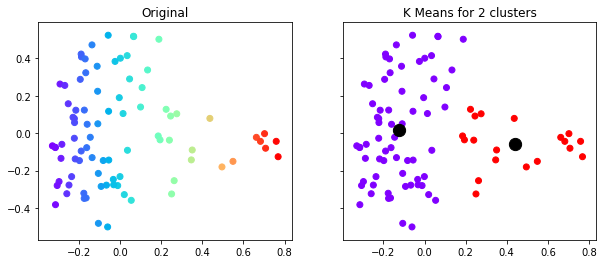

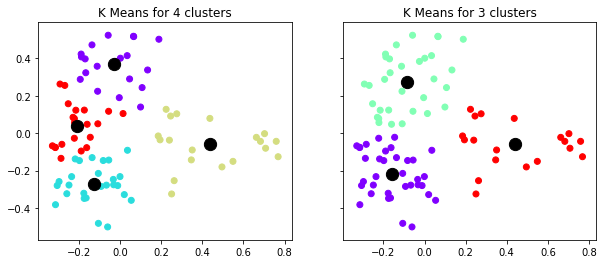

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,4))
ax1.set_title('Original')
ax1.scatter(whisky_features_reduced[:,0],whisky_features_reduced[:,1],c = whisky_features_reduced[:,0],cmap='rainbow')

ax2.set_title('K Means for 2 clusters')
ax2.scatter(whisky_features_reduced[:,0],whisky_features_reduced[:,1],c=kmeans_2_clusters.labels_,cmap='rainbow')
ax2.scatter(kmeans_2_clusters.cluster_centers_[:, 0], kmeans_2_clusters.cluster_centers_[:, 1], s=150, c = 'black')

f, (ax4, ax3) = plt.subplots(1, 2, sharey=True,figsize=(10,4))
ax3.set_title('K Means for 3 clusters')
ax3.scatter(whisky_features_reduced[:,0],whisky_features_reduced[:,1],c=kmeans_3_clusters.labels_,cmap='rainbow')
ax3.scatter(kmeans_3_clusters.cluster_centers_[:, 0], kmeans_3_clusters.cluster_centers_[:, 1], s=150, c = 'black')

ax4.set_title('K Means for 4 clusters')
ax4.scatter(whisky_features_reduced[:,0],whisky_features_reduced[:,1],c=kmeans_4_clusters.labels_,cmap='rainbow')
ax4.scatter(kmeans_4_clusters.cluster_centers_[:, 0], kmeans_4_clusters.cluster_centers_[:, 1], s=150, c = 'black')

plt.show()


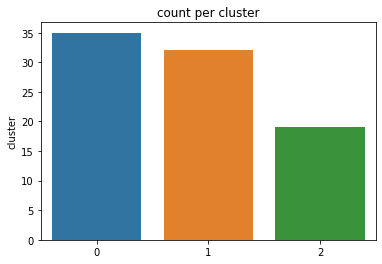

In [48]:
df['cluster']= pred_y_3_clusters
clusters= df.cluster.value_counts()
sns.barplot(x=clusters.index, y=clusters)
plt.title('count per cluster')
plt.show()

- Majority of the distilleries are in cluster 0
- The least number of distilleries are in cluster 2

In [49]:
#Populate the 3 lists from the dataframe
cluster0, cluster1, cluster2 =[],[] ,[]
cluster_list= [cluster0, cluster1, cluster2]
for idx, each in enumerate(cluster_list):
    cluster_list[idx].append(df.Distillery[df.cluster==idx].values[:])

#change them into lists instead of nested lists with length 1 
cluster0, cluster1, cluster2= list(cluster0[0]) ,list(cluster1[0]) ,list(cluster2[0])

#concat the lists regardless of their lengths
table_entries= zip_longest(cluster0, cluster1, cluster2)

In [50]:
display(HTML(
    """
        <table style='width:50%'><tr>
        <th>cluster0</th>
        <th>cluster1</th>
        <th>cluster2</th>
        </tr>
    """
   '<tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(entry) if entry else '' for entry in row)) for row in table_entries)
       )
))

cluster0,cluster1,cluster2
AnCnoc,Aberfeldy,Ardbeg
ArranIsleOf,Aberlour,Balblair
Auchentoshan,Ardmore,Bowmore
Aultmore,Auchroisk,Bruichladdich
Benriach,Balmenach,Caol Ila
Bladnoch,Belvenie,Clynelish
Bunnahabhain,BenNevis,GlenDeveronMacduff
Cardhu,Benrinnes,GlenGarioch
Craigganmore,Benromach,GlenScotia
Dalwhinnie,BlairAthol,Highland Park


### Table usage

#### Business

- If a person is interested in running or owning a distillery that is already existing, they can use the table above to see the different types of distilleries per cluster. 
- I may not have facts on the following, however i think that the reason a certain cluster may have the most distilleries is simply because most people in the given geographic location where the distilleries sell their whiskey prefer whiskey of that kind of a taste, otherwise, these distilleries would not have been part of our dataset as they would have closed down due to lack of profits, also taking into consideration the time in which the dataset was compiled is important.

#### Investors
- This table may not be a guaranteed guideline to profitable distilleries or even whiskey sales,however the table above can give a bit of a broader view as to which type  of distillery or whiskey to invest capital in according to popularity in whiskey's tasting profile given the geographic location, although more investigation should be made with regards to the pricing and sales of each distillery. This approach can be used in an instant whereby an organization or individual wants to invest capital in a distillery in the hope of gaining more returns on their investment.

#### Researchers
- According to the clustering algorithm, the clusters are made up of distilleries that make whiskey which tastes similar , nonetheless, there could be more that links these distilleries together that goes far beyond their tastes, such as similarity in prices, or even the process of making the mouth watering whiskey, including answering the questions behind the difference in cluster population, could it imply that the cluster with most whiskey has a more favourable taste thus it is competitive?, or could it be that it is a matter of geographic location in which people can access the whiskey each distillery produces is spread apart?. All these fascinating questions, and there are more of them depending on the purpose of study/research in trying to assess the whiskey market can be answered by researchers, These questions have been sparked by the table above.

#### Whiskey tourism. Yup its a thing and its booming.
- Whiskey tourists can use the cluster to identify a cluster with a specific tasting profile,than use the table to select the distillery which the whiskey is made so they can go site seeing of how the whiskey is made, given that the distilleries are welcoming and have an open door policy to visitors 

### Cluster insights

- These clusters are build based on their similarity in tasting profiles 

#### How are the clusters useful ?

- For the adventurous whiskey lovers who would like to try out other whisky drinks,can use the clusters to find whiskeys of similar tastes

#### This is only useful for people who already know how a whiskey tastes, what about first time whiskey drinkers who want to know the flavours of the whiskey before they can try a whiskey out?

### Dominant flavours in each clusters

In [51]:
df_clusters = pd.concat([whisky_features,clusters],axis = 1)
df_clusters = df_clusters.dropna()
features_grouped_by_clusters = df_clusters.groupby('cluster').mean()

In [52]:
index_ = ['Cluster2','Cluster1','Cluster0']
features_grouped_by_clusters.index = index_

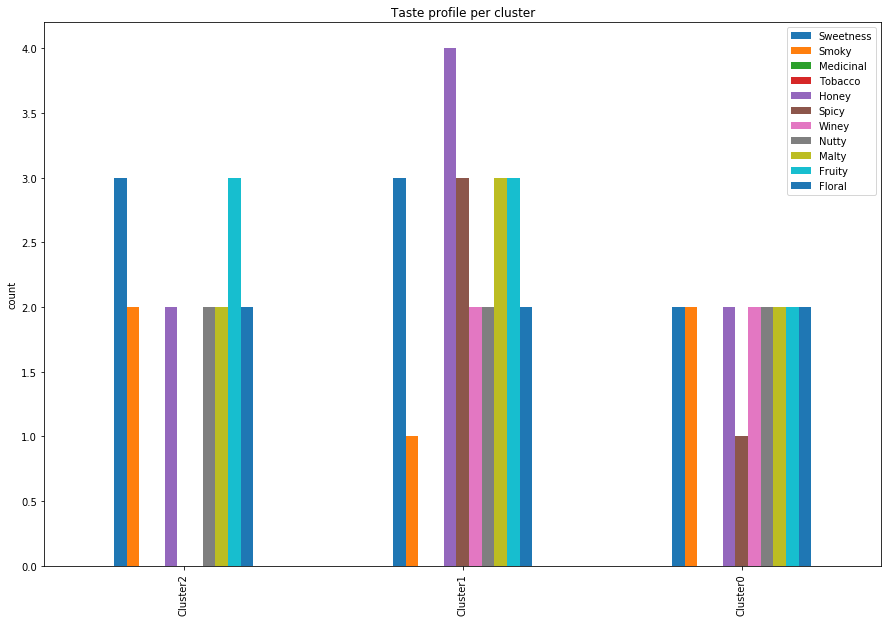

In [53]:
features_grouped_by_clusters.plot.bar(figsize=(15,10))
plt.ylabel("count")
plt.title("Taste profile per cluster");

In [54]:
features_grouped_by_clusters

,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral
Cluster2,3,2,0,0,2,0,0,2,2,3,2
Cluster1,3,1,0,0,4,3,2,2,3,3,2
Cluster0,2,2,0,0,2,1,2,2,2,2,2


### Insights on the flavours per cluster

### General Insights
- For all three clusters
    - Smoky and Sweetness seem to be flavours that blend together, separated from the other flavours
    - There is no account for Medicinal and Tobacco in all the clusters
    - Honey seems to be grouped together with Spicy

### Detailed Insights

###### Cluster 2:
- Has a dominant sweet and fruity flavour
- With a balance of floral, malty, honey and smoky flavours

###### Cluster 1:
- Has a dominating honey flavour
- With a low quantity of smoky flavour
- This cluster seems to have the same count for sweetness, spicy, malt and fruit
- And a balance of winey, nutty and floral

###### Cluster 0:
- With spicy having a low quantity in the cluster
- This cluster is made up with a balanced blend of all the flavours excluding,  medicinal and tobacco

#### People who want to choose a whiskey based on its tasting profile can than use the plot above to know which cluster their preference is in, than move on to the previous section to select a whiskey distillery to know where their preferred whiskey is made according to their flavours


### References

- http://www.cse.ust.hk/~qyang/537/Papers/huang98extensions.pdf
- https://reneshbedre.github.io/blog/pca_3d.html
- https://datascience.stackexchange.com/questions/16700/confused-about-how-to-apply-kmeans-on-my-a-dataset-with-features-extracted
- https://prasant.net/clustering-scotch-whisky-grouping-distilleries-by-k-means-clustering-81f2ecde069c
- https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a
- https://www.bmmagazine.co.uk/in-business/why-is-whisky-tourism-booming/